In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from tqdm import tqdm

In [125]:

class Particle:
    
    def __init__(self, r0, v0, a0, t, m=1, radius=2., Id=0):
        
        self.dt = t[1] - t[0]
        
        
        # Atributos instantaneos
        self.r = r0
        self.v = v0
        self.a = a0
        
        self.m = m
        self.radius = radius
        self.Id = Id
        
        
        self.p = self.m*self.v
        
        self.f = self.m*self.a
        
        # Historial
        
        self.R = np.zeros((len(t),len(r0)))
        self.V = np.zeros_like(self.R)
        self.A = np.zeros_like(self.R)
        
        self.F = np.zeros_like(self.R)
        
        self.P = np.zeros_like(self.R)
    
        # Fisica
        self.K = 20.
        
        self.VEk = np.zeros(len(t))
        self.EU=np.zeros_like(self.VEk)
        
    def Evolution(self,i):
        
        
        self.SetPosition(i)
        self.SetVelocity(i)
        
        self.a = self.f/self.m
        
        # Euler
       # self.r += self.dt*self.v
       # self.v += self.dt*self.a
        
        # Euler-Cromer
        self.v += self.dt*self.a
        self.r += self.dt*self.v
        
        
    def CalculateForce(self,p):
        
        d = np.linalg.norm(self.r - p.r)
        
        compresion = self.radius + p.radius - d
        
        if compresion >= 0:
            
            Fn = self.K * compresion**3
            
            self.n = (self.r - p.r)/d     
            self.f = np.add(self.f,Fn*self.n)
            # Falta implementar energía potencial
            
    def SetPotential(self,i,p):
        
        d = np.linalg.norm(self.r - p.r)
        
           
        compresion = self.radius + p.radius - d
        
        if compresion >= 0:

            self.EU[i]= -self.K*d*(self.radius+p.radius -(d**3)/4)
                              
     
    # Aca debes agregar la energía potencial
    def ResetForce(self):
        self.f[:] = 0.
        self.a[:] = 0.
    
    # Setter
    def SetPosition(self,i):
        self.R[i] = self.r
    
    def SetVelocity(self,i):
        self.V[i] = self.v
        self.P[i] = self.m*self.v
        self.VEk[i] = 0.5*self.m*np.dot(self.v,self.v)
    
    # Getter
    def GetPosition(self,scale=1):
        return self.R[::scale]
    
    def GetVelocity(self,scale=1):
        return self.V[::scale]
 
    def GetMomentum(self,scale=1):
        return self.P[::scale]
    
    def GetKineticEnergy(self,scale=1):
        return self.VEk[::scale] 
                              
    def GetPotential(self,scale=1):
        return self.EU[::scale] 
    
    # Debes agregar las paredes en este punto

In [126]:
def GetParticles(N,t):
    
    
    
    # Aca deber agregar una rutina montecarlo para crear particulas
    # sobre el plano con velocidades aleatorias.
    
    Particles = []
    
    r_= np.random.uniform(-20.,20.,[N,2])
    v_=np.random.uniform(-5.,5.,[N,2])
    a_=np.zeros_like(v_)
    
    print(r_)
    
    for i in range(N):
      
      Particles.append(Particle(r_[i],v_[i],a_[i],t,m=1,radius=2,Id=i))
        
    
    return Particles

In [127]:
dt = 0.001
tmax = 10
t = np.arange(0,tmax,dt)

In [128]:
def RunSimulation(t,Particles):
    
    for it in tqdm(range(len(t)), desc='Running simulation', unit=' Steps' ):
        
        for i in range(len(Particles)):
            for j in range(len(Particles)):
                if i!=j:
                    Particles[i].CalculateForce(Particles[j])
                    Particles[i].SetPotential(it,Particles[j])
        
        for i in range(len(Particles)):
            Particles[i].Evolution(it)
            Particles[i].ResetForce()
            # Aca debes agregar la interaccion con la pared
            
            
    return Particles

In [129]:
Particles = GetParticles(10,t)
Particles = RunSimulation(t,Particles)


[[ -8.581704    -9.94295668]
 [ 12.60289874 -11.95775407]
 [ 19.27920811  -5.28977738]
 [ -1.2148361  -13.01504886]
 [ -0.9916577   14.63818496]
 [-17.5205246   -1.30006229]
 [ -7.36053018   8.51360496]
 [ 13.4851071   -3.93110917]
 [-13.96451904   6.96377141]
 [-15.94299841  -8.98571349]]


Running simulation: 100%|███████████████████████████████████████████████████| 10000/10000 [00:13<00:00, 720.60 Steps/s]


In [130]:
# Bajamos dimensión de la simulacion
scale = 200
t1 = t[::scale]

<IPython.core.display.Javascript object>


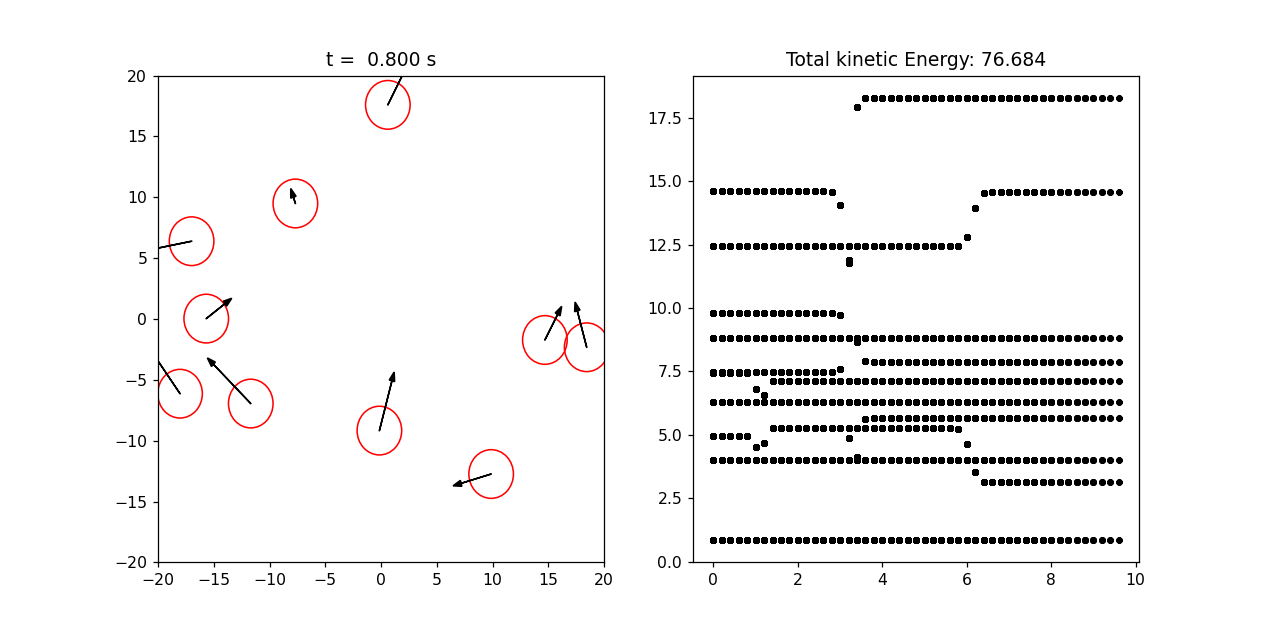

In [131]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)
ax1 = fig.add_subplot(122)

def init():
    
    ax.clear()
    ax.set_xlim(-20,20)
    ax.set_ylim(-20,20)
    
def Update(i):
    
    init()
    ax.set_title(r't =  %.3f s' %(t1[i]))
    
    
    # Queremos calcular la energía total de cinética
    KE = 0. # Kinetic energy
    
    for p in Particles:
        
        x = p.GetPosition(scale)[i,0]
        y = p.GetPosition(scale)[i,1]
        
        vx = p.GetVelocity(scale)[i,0]
        vy = p.GetVelocity(scale)[i,1]
        
        circle = plt.Circle( (x,y), p.radius, color='r', fill=False )
        ax.add_patch(circle)
        
        ax.arrow(x,y,vx,vy,color='k',head_width=0.5,length_includes_head=True)
        
        KE += p.GetKineticEnergy(scale)[i]
        
        ax1.set_title(r'Total kinetic Energy: {:.3f}'.format(KE))
        ax1.scatter(t1[:i], p.GetKineticEnergy(scale)[:i],color='k',marker='.')
        
Animation = anim.FuncAnimation(fig,Update,frames=len(t1),init_func=init)

In [132]:
MomentumT = Particles[0].GetMomentum(scale)
for i in range(1,len(Particles)):
    MomentumT = np.add(MomentumT,Particles[i].GetMomentum(scale))
    
KineticT = Particles[0].GetKineticEnergy(scale)
PotentialT = Particles[0].GetPotential(scale)


for i in range(1,len(Particles)):
    KineticT = np.add(KineticT,Particles[i].GetKineticEnergy(scale))
    PotentialT = np.add(PotentialT,Particles[i].GetPotential(scale))
    
PotentialT
KineticT


array([76.69239984, 76.69239984, 76.69239984, 76.69239984, 76.68421428,
       75.63730045, 75.56793125, 76.68093978, 76.69239984, 76.69239984,
       76.69239984, 76.69239984, 76.69239984, 76.69239984, 76.6882337 ,
       76.20033783, 73.36291454, 75.49767748, 76.65118515, 76.69239984,
       76.69239984, 76.69239984, 76.69239984, 76.69239984, 76.69239984,
       76.69239984, 76.69239984, 76.69239984, 76.69239984, 76.66869272,
       76.40637817, 76.46448494, 76.68372948, 76.69239984, 76.69239984,
       76.69239984, 76.69239984, 76.69239984, 76.69239984, 76.69239984,
       76.69239984, 76.69239984, 76.69239984, 76.69239984, 76.69239984,
       76.69239984, 76.69239984, 76.69239984, 76.69239984, 76.69239984])

<IPython.core.display.Javascript object>


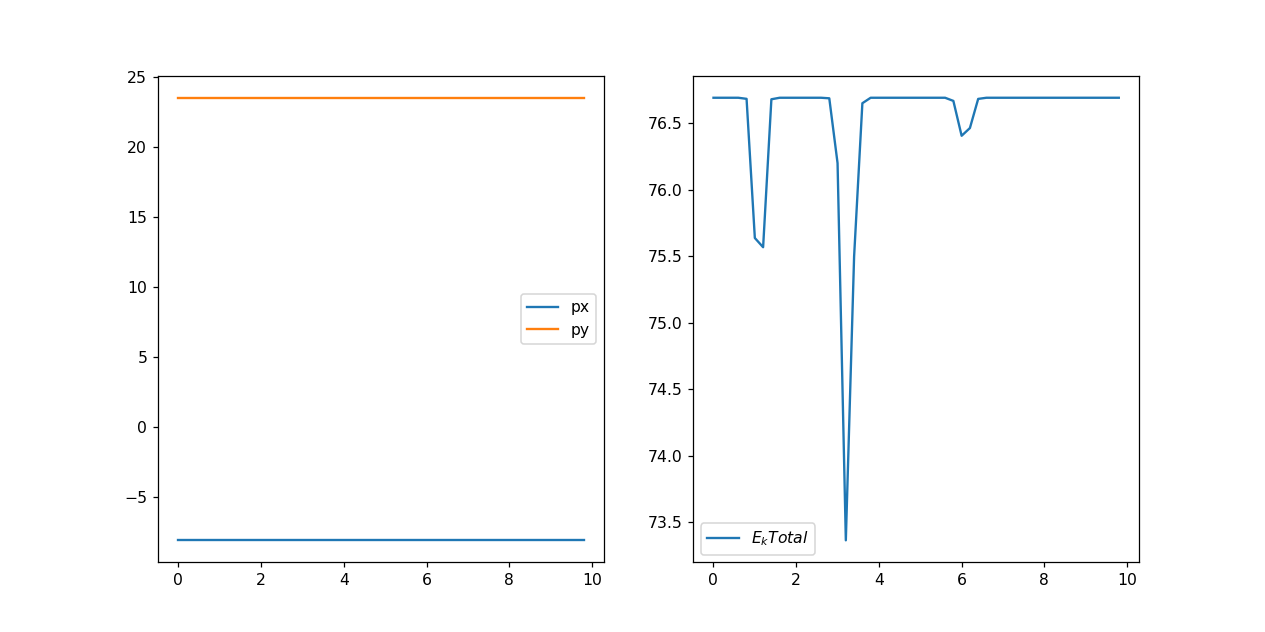

In [133]:
fig3 = plt.figure(figsize=(10,5))
ax3 = fig3.add_subplot(121)
ax3.plot(t1,MomentumT[:,0],label='px')
ax3.plot(t1,MomentumT[:,1],label='py')
ax3.legend()


ax4 = fig3.add_subplot(122)
ax4.plot(t1,KineticT,label='$E_k Total$')
ax4.legend()




<IPython.core.display.Javascript object>


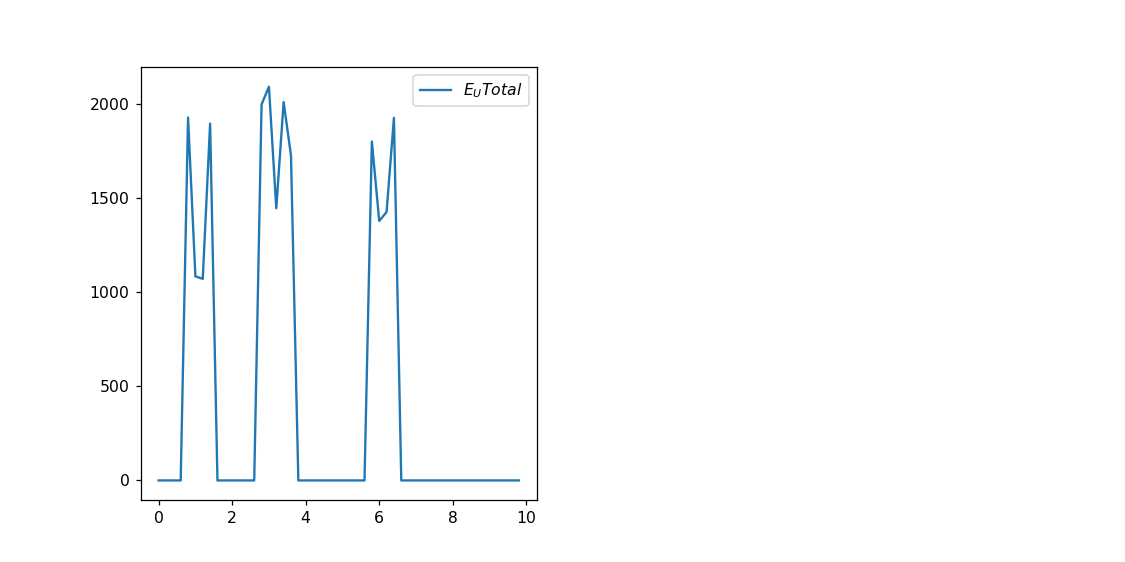

In [134]:
fig4 = plt.figure(figsize=(10,5))
ax5 = fig4.add_subplot(121)
ax5.plot(t1,PotentialT,label='$E_U Total$')
ax5.legend()

<IPython.core.display.Javascript object>


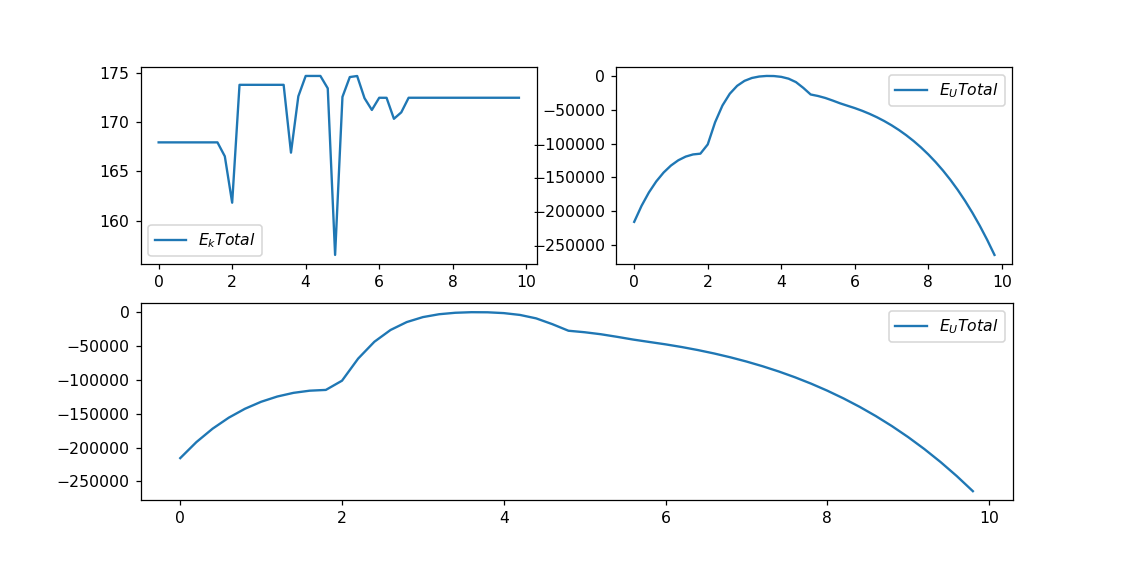